<h1> 벡터 데이터 분석 <h1>  

### Shapely, OGR, GeoPandas 같은 벡터 데이터를 분석하고 처리하는 데 사용되는 파이썬 라이브러리 다루기  

* 벡터 데이터 읽기 및 쓰기  
* 벡터 데이터 생성 및 처리  
* 지도에서 벡터 데이터 시각화  
* 지도 투영 및 데이터 재투영 작업  
* 공간 결합과 같은 공간 연산 수행  
* 데이블 형식으로 벡터 지오메트리 및 속성 데이터 작업  
* 영역 x 내 산불 횟수에 관한 질문에 답하기 위한 결과 분석  

<h1>OGR Simple Features Library</h1>

OGR 라이브러리: 벡터 데이터 설명 및 처리
OGR 배치 명령
* ogrinfo: 벡터 데이터의 정보(포멧, 사용가능 레이어, 요약)  
* ogr2ogr: 포멧 변경  

<h2>ogrmerge.py example</h2>

In [1]:
%run "/Users/choyeon/opt/anaconda3/pkgs/gdal-2.2.2-py36hd505dc6_1/lib/python3.6/site-packages/GDAL-2.2.2-py3.6-macosx-10.9-x86_64.egg-info/scripts/ogrmerge.py" -f GPKG -o merged.gpkg "/Users/choyeon/Documents/SIA/study/data/NE/10m_cultural/*.shp"

## OGR 주요 모듈과 코드

<h2>OGR code examples</h2>

In [15]:
# Example 1 – create polygon geometry with OGR
### OGR로 폴리곤 데이터 생성하기
from osgeo import ogr
r = ogr.Geometry(ogr.wkbLinearRing)
r.AddPoint(1,1)
r.AddPoint(5,1)
r.AddPoint(5,5)
r.AddPoint(1,5)
r.AddPoint(1,1)
poly = ogr.Geometry(ogr.wkbPolygon)
poly.AddGeometry(r)
print(poly.ExportToWkt())

POLYGON ((1 1 0,5 1 0,5 5 0,1 5 0,1 1 0))


In [14]:
# Example 2 – create polygon geometry from GeoJSON
### GeoJSON에서 콜리곤 지오메트리 생성하기
from osgeo import ogr
geojson = """{"type":"Polygon","coordinates":[[[1,1],[5,1],[5,5],[1,5], [1,1]]]}"""
polygon = ogr.CreateGeometryFromJson(geojson)
print(polygon) 

POLYGON ((1 1,5 1,5 5,1 5,1 1))


In [16]:
# Example 3 - basic geometric operations
### 기본 지오메트리 연산
# 1 create area
### 영역 생성
print("The area of our polygon is %d" % polygon.Area())

The area of our polygon is 16


In [17]:
# 2 calculate centroid of polygon
### 폴리곤 중심점 계산
cen = polygon.Centroid()
print(cen)

POINT (3 3)


In [18]:
# 3 Get the boundary
### 경계 얻기
b = polygon.GetBoundary()
print(b)

LINESTRING (1 1,5 1,5 5,1 5,1 1)


In [19]:
# 4 convex hull does the same in this case as boundary, as our polyogn is a square:
### 볼록 선체 경계
ch = polygon.ConvexHull() 
print(ch)

POLYGON ((1 1,1 5,5 5,5 1,1 1))


In [20]:
#5 buffer. A buffer value of 0 (zero) returns the same values as boundary and convex hull in this example:
### 버퍼가 0이면 경계와 동일
buffer = polygon.Buffer(0) 
print(buffer)

POLYGON ((1 1,1 5,5 5,5 1,1 1))


In [21]:
# 6 check if a point is inside our polygon
### 포인트가 폴리곤 내부에 있는지 판단
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(10, 10)
polygon.Contains(point)

False

In [32]:
#Example 4 – writing polygon data to a newly created shapefile
### 신규 쉐이프 파일에 폴리곤 데이터 쓰기

import osgeo.ogr, osgeo.osr
# 1 set the spatial reference
### 공간 참조 설정
spatialReference = osgeo.osr.SpatialReference()
spatialReference.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# 2 create a new shapefile
### 쉐이프 파일 생성
driver = osgeo.ogr.GetDriverByName('ESRI Shapefile')
shapeData = driver.CreateDataSource('my_polygon.shp')

# 3 create the layer
### 레이어 생성
layer = shapeData.CreateLayer('polygon_layer', spatialReference, osgeo.ogr.wkbPolygon)
layerDefinition = layer.GetLayerDefn()

# 4 geometry is put inside feature
### 지오메트리 입력
featureIndex = 0
feature = osgeo.ogr.Feature(layerDefinition)
feature.SetGeometry(polygon)
feature.SetFID(featureIndex)

# 5 feature is put into layer
### 입력값 출력
layer.CreateFeature(feature)

0

In [33]:
!ogrinfo my_polygon.shp

INFO: Open of `my_polygon.shp'
      using driver `ESRI Shapefile' successful.
1: my_polygon (Polygon)


In [34]:
#Example 5 – using a spatial filter to select features
### 공간 필터를 사용해 특징 선택하기
# import the modules
from osgeo import ogr
import os

# reference the shapefile and specify driver type
shapefile = r"/Users/choyeon/Documents/SIA/study/data/NE/10m_cultural/ne_10m_populated_places.shp"
driver = ogr.GetDriverByName("ESRI Shapefile")

# open the data source with driver, zero means open in read-only mode
### 데이터 열기
dataSource = driver.Open(shapefile, 0)

# use the GetLayer() function for referencing the layer that holds the data
### 데이터의 레이어 참조
layer = dataSource.GetLayer()

# pass in the coordinates for the data frame to the SetSpatialFilterRect() function.
# this filter creates a rectangular extent and selects the features inside the extent
### 좌표값 사각형의 내부값 가져오기
layer.SetSpatialFilterRect(-102, 26, -94, 36)
for feature in layer:
    # select only the cities inside of the USA
    # we can do this through a SQL query:
    # we skip the cities that are not in the USA,
    # and print the names of the cities that are
    ### 미국 내 도시 이름 출력
    if feature.GetField("ADM0NAME") != "United States of America":
        continue
    else:
        print(feature.GetField("NAME"))

Ardmore
McAlester
Bryan
San Marcos
Longview
McAllen
Harlingen
Alice
New Braunfels
Cleburne
Brownwood
Big Spring
Vernon
Childress
Texas City
Pasadena
Baytown
Arlington
Texarkana
Fort Smith
Lawton
Norman
Muskogee
Shawnee
Conroe
Nacogdoches
Eagle Pass
Edinburg
Kingsville
Huntsville
Killeen
Lufkin
Del Rio
San Angelo
Sherman
Beaumont
Bay City
Port Lavaca
Falfurrias
Beeville
Dumas
Denton
Temple
Galveston
Freeport
Victoria
Wichita Falls
Waco
Lubbock
Abilene
Tyler
Ft. Worth
Corpus Christi
Austin
Amarillo
Laredo
Oklahoma City
San Antonio
Dallas
Houston


<h1>Shapely and Fiona</h1>

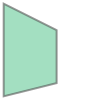

In [1]:
# Example 1 – create geometries with Shapely
### Shapely로 지오메트리 생성

from shapely.geometry import Polygon

p1 = Polygon(((1, 2), (5, 3), (5, 7), (1, 9), (1, 2)))
p2 = Polygon(((6,6), (7,6), (10,4), (11,8), (6,6)))
p1 

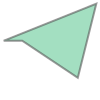

In [2]:
# A new command line is required for printing the second polygon:
### 
p2

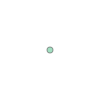

In [3]:
# Point takes tuples as well as positional coordinate values
### 위치좌표
from shapely.geometry import Point
point = Point(2.0, 2.0)
q = Point((2.0, 2.0))
q

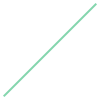

In [4]:
# line geometry
### 선
from shapely.geometry import LineString
line = LineString([(0, 0), (10,10)])
line

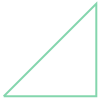

In [5]:
# linear rings
### 선형 rings
from shapely.geometry.polygon import LinearRing
ring = LinearRing([(0,0), (3,3), (3,0)])
ring

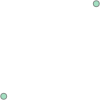

In [6]:
# collection of points
### 여러 점
from shapely.geometry import MultiPoint
points = MultiPoint([(0.0, 0.0), (3.0, 3.0)])
points

In [7]:
# collection of lines
### 여러 선
from shapely.geometry import MultiLineString
coords = [((0, 0), (1, 1)), ((-1, 0), (1, 0))]
coords

[((0, 0), (1, 1)), ((-1, 0), (1, 0))]

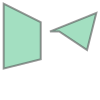

In [8]:
# collection of polygons
### 여러 도형
from shapely.geometry import MultiPolygon
polygons = MultiPolygon([p1, p2,])
polygons

In [9]:
#Example 2 – apply geometrical methods with Shapely
### Shapely 지오메트리 메서드 사용
print(p1.area) ### 면적
print(p1.bounds) ### 꼭지점
print(p1.length) ### 둘레
print(p1.geom_type) ### 형태

22.0
(1.0, 2.0, 5.0, 9.0)
19.59524158061724
Polygon


In [10]:
#Example 3 – reading JSON geometries with v
### Shapely로 JSON 읽기
import json
from shapely.geometry import mapping, shape
p = shape(json.loads('{"type": "Polygon", "coordinates": [[[1,1], [1,3 ], [3,3]]]}'))
print(json.dumps(mapping(p)))
p.area

{"type": "Polygon", "coordinates": [[[1.0, 1.0], [1.0, 3.0], [3.0, 3.0], [1.0, 1.0]]]}


2.0

In [11]:
# Example 4 – reading data with Fiona
### Fiona 데이터 읽기

import fiona
c = fiona.open(r"/Users/choyeon/Documents/SIA/study/data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")
rec = next(iter(c))
rec.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [16]:
import pprint
pprint.pprint(rec['type'])
pprint.pprint(rec['id'])
pprint.pprint(rec['properties'])
pprint.pprint(rec['geometry'])

'Feature'
'0'
OrderedDict([('featurecla', 'Admin-1 scale rank'),
             ('scalerank', 2),
             ('adm1_code', 'USA-3514'),
             ('diss_me', 3514),
             ('iso_3166_2', 'US-MN'),
             ('wikipedia', 'http://en.wikipedia.org/wiki/Minnesota'),
             ('iso_a2', 'US'),
             ('adm0_sr', 1),
             ('name', 'Minnesota'),
             ('name_alt', 'MN|Minn.'),
             ('name_local', None),
             ('type', 'State'),
             ('type_en', 'State'),
             ('code_local', 'US27'),
             ('code_hasc', 'US.MN'),
             ('note', None),
             ('hasc_maybe', None),
             ('region', 'Midwest'),
             ('region_cod', None),
             ('provnum_ne', 0),
             ('gadm_level', 1),
             ('check_me', 20),
             ('datarank', 1),
             ('abbrev', 'Minn.'),
             ('postal', 'MN'),
             ('area_sqkm', 0),
             ('sameascity', -99),
             ('labelran

In [17]:
print(len(c))        # prints total amount of features     
print(c.driver)      # prints driver name
print(c.crs)         # prints coordinate reference system of data file

51
ESRI Shapefile
{'init': 'epsg:4326'}


In [21]:
#Example 5 – accessing vector geometry in shapefiles using Shapely and Fiona

import pprint, fiona

with fiona.open(r"/Users/choyeon/Documents/SIA/study/data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp") as src:
    pprint.pprint(src[0])

{'geometry': {'coordinates': [[(-89.95765601272012, 47.286907253603175),
                               (-90.13175391311144, 47.29274669045216),
                               (-90.30585181350276, 47.29801768654593),
                               (-90.47994971389409, 47.30385712339489),
                               (-90.6540476142854, 47.309128119488676),
                               (-90.85778194859611, 47.21282908791278),
                               (-91.06097368036777, 47.117046820659795),
                               (-91.26470801467849, 47.02126455340681),
                               (-91.46844234898919, 46.9249655218309),
                               (-91.59225908076053, 46.876260484395914),
                               (-91.71661841507091, 46.82760712339301),
                               (-91.8409777493813, 46.778385321635),
                               (-91.96479448115262, 46.72970612241605),
                               (-92.01189754918667, 46.7117227239

In [22]:
from shapely.geometry import shape
minnesota = {'type': 'Polygon', 'coordinates': [[(-89.61369767938538, 47.81925202085796), (-89.72800594761503, 47.641976019880644), (-89.84283098016755, 47.464725857119504), (-89.95765601272012, 47.286907253603175), (-90.13175391311144, 47.29274669045216), (-90.30585181350276, 47.29801768654593), (-90.47994971389409, 47.30385712339489), (-90.6540476142854, 47.309128119488676), (-90.85778194859611, 47.21282908791278), (-91.06097368036777, 47.117046820659795), (-91.26470801467849, 47.02126455340681), (-91.46844234898919, 46.9249655218309), (-91.59225908076053, 46.876260484395914), (-91.71661841507091, 46.82760712339301), (-91.8409777493813, 46.778385321635), (-91.96479448115262, 46.72970612241605), (-92.01189754918667, 46.71172272397848), (-92.27487891312, 46.65614472104858), (-92.26482784703924, 46.09522288673644), (-92.2965830146826, 46.09628225359842), (-92.54369971390233, 45.98569468849381), (-92.75696834997089, 45.88991242124082), (-92.89982784704182, 45.705763454768714), (-92.68922054723626, 45.51843638771068), (-92.76541744665064, 45.26708222104298), (-92.76647681351261, 44.9961426865367), (-92.79665584997105, 44.77602692318949), (-92.50507158076417, 44.58391978614445), (-92.38549231644078, 44.57492808692567), (-92.06215287959051, 44.43258535417769), (-91.949989183301, 44.364837551443046), (-91.87960588251947, 44.25742808692439), (-91.62770911331273, 44.085448920257036), (-91.28959021682704, 43.93729258887629), (-91.25729244664458, 43.854739488289965), (-91.2546569485977, 43.61397899024206), (-91.22819861526426, 43.5012468531974), (-92.54000484899348, 43.51977285417405), (-94.00102678096546, 43.51341665300214), (-95.35993608272871, 43.50018748633542), (-96.4526600817565, 43.50178945573647), (-96.43943091508982, 44.43576345476367), (-96.56061214881424, 45.39301768653837), (-96.73576941606754, 45.47081655535372), (-96.83470394569034, 45.62532908790642), (-96.78072791216147, 45.76079885515958), (-96.55689144568922, 45.87244578712617), (-96.53945064979075, 46.017966620460186), (-96.53890804725165, 46.199480088885366), (-96.60135901567638, 46.3513571233911), (-96.68548824744755, 46.51328522397769), (-96.73365068234358, 46.71647695574927), (-96.7458204821483, 46.9445250514533), (-96.77969438351563, 46.999043687521294), (-96.82041541216165, 47.29220408791309), (-96.82465287960957, 47.42661448830425), (-96.84423824744819, 47.54619375262766), (-96.89397681352912, 47.74886872007637), (-97.01515804725355, 47.954205023788134), (-97.13104244666809, 48.13729462339825), (-97.14850908078273, 48.31878225360731), (-97.16122148312654, 48.51458425556122), (-97.12734758175921, 48.64212169045756), (-97.1204746162644, 48.75852285419501), (-97.21413814979343, 48.90244171812793), (-97.22894344764504, 49.00088532164389), (-95.15883724646483, 48.9998259547819), (-95.15620174841791, 49.38401439065592), (-94.81754024939323, 49.38928538674975), (-94.64026424841592, 48.84001658791925), (-94.32912044958647, 48.670672919298795), (-93.63061011429733, 48.60928131773602), (-92.60984554723586, 48.45001455341253), (-91.63987891311746, 48.13993012144516), (-90.83026424840062, 48.27010305438836), (-89.59995174839577, 48.01027395282483), (-89.59940914585667, 48.01027395282483), (-89.4900319346622, 48.01340602289096), (-89.52269548211933, 47.96053538674391), (-89.61369767938538, 47.81925202085796)]]}

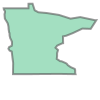

In [23]:
geom = shape(minnesota)
geom

<h1>GeoPandas</h1>

In [8]:
# Example 1 – selecting and plotting geometry data with GeoPandas and Matplotlib
### GeoPandas와 Matplotlib으로 지오메트리 데이터 플로팅하기
# import module
import geopandas as gpd
# magic command to use matplotlib plots inside Jupyter Notebook app
%matplotlib inline
# create a GeoDataFrame from shapefile and display it
df = gpd.read_file(r"/Users/choyeon/Documents/SIA/study/data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")
df.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,Minnesota,Minnesota,Minnesota,Миннесота,Minnesota,Minnesota,Minnesota,明尼蘇達州,1159315297,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,Montana,Montana,Montana,Монтана,Montana,Montana,Montana,蒙大拿州,1159315333,"POLYGON ((-116.04823 49.00037, -113.05950 49.0..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,North Dakota,Dakota Północna,Dakota do Norte,Северная Дакота,North Dakota,Kuzey Dakota,Bắc Dakota,北达科他州,1159315337,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."


In [9]:
# return object type
type(df)

geopandas.geodataframe.GeoDataFrame

In [10]:
# shape prints rows and columns
df.shape

(51, 84)

In [11]:
# columns returns column names as a list item
df.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local',
       'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe',
       'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me',
       'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank',
       'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id',
       'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3',
       'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name',
       'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code',
       'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1',
       'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid',
       'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr',
       'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja',
       'name_ko', 'name_nl', 'name_pl', 'name_

In [12]:
# subset data using pandas' dataframe .loc method
df.loc[0]

featurecla                                   Admin-1 scale rank
scalerank                                                     2
adm1_code                                              USA-3514
diss_me                                                    3514
iso_3166_2                                                US-MN
                                    ...                        
name_tr                                               Minnesota
name_vi                                               Minnesota
name_zh                                                   明尼蘇達州
ne_id                                                1159315297
geometry      POLYGON ((-89.95765601272012 47.28690725360318...
Name: 0, Length: 84, dtype: object

In [13]:
# print a list of all state names
df['name'].head()

0       Minnesota
1         Montana
2    North Dakota
3          Hawaii
4           Idaho
Name: name, dtype: object

In [14]:
# reference a separate row and print all columns and attribute data
california = df.loc[df['name'] == "California"]
california

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
7,Admin-1 scale rank,2,USA-3521,3521,US-CA,http://en.wikipedia.org/wiki/California,US,8,California,CA|Calif.,...,Californië,Kalifornia,Califórnia,Калифорния,Kalifornien,Kaliforniya,California,加利福尼亚州,1159308415,"POLYGON ((-114.64222 35.05311, -114.62212 34.9..."


<AxesSubplot:>

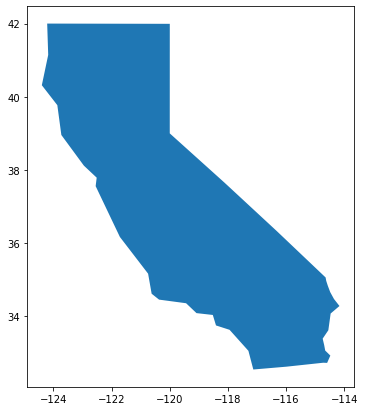

In [15]:
# plot state geometry
california.plot(figsize=(7,7))

<AxesSubplot:>

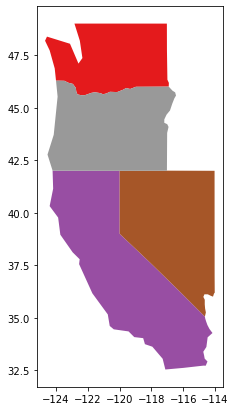

In [16]:
# subset and plot multiple items using .iloc method
### 워싱턴, 캘리포니아, 네바다, 오리선
### 행 번호로 추출
multipl = df.iloc[[5,7,9,11]]
multipl.plot(cmap="Set1", figsize=(7,7))

<AxesSubplot:>

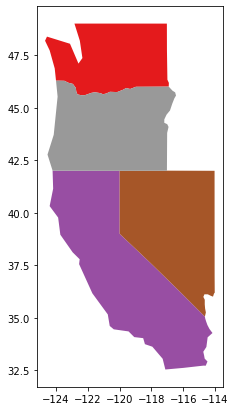

In [17]:
# subset items using .cx method and a bounding box and plot them
### 경계상자: xmin:xmax, ymin:ymax
exp = df.cx[-124:-118,30:50]
exp.plot(cmap="Set1", figsize=(7,7))

In [18]:
# Example 2 – mapping wildfire data with GeoPandas
# import module
import geopandas

In [19]:
# import shapefile with state geometries
states = geopandas.read_file(r"/Users/choyeon/Documents/SIA/study/data/NE/110m_cultural/ne_110m_admin_1_states_provinces.shp")

In [20]:
# display attribute table
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,Minnesota,Minnesota,Minnesota,Миннесота,Minnesota,Minnesota,Minnesota,明尼蘇達州,1159315297,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,Montana,Montana,Montana,Монтана,Montana,Montana,Montana,蒙大拿州,1159315333,"POLYGON ((-116.04823 49.00037, -113.05950 49.0..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,North Dakota,Dakota Północna,Dakota do Norte,Северная Дакота,North Dakota,Kuzey Dakota,Bắc Dakota,北达科他州,1159315337,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."


<AxesSubplot:>

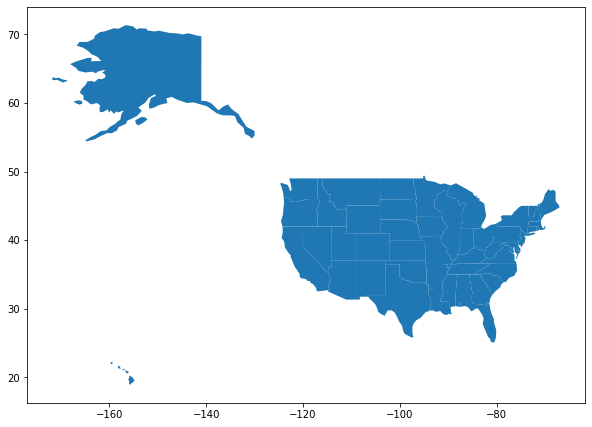

In [21]:
# magic command for using matplotlib, next plot state geometries
%matplotlib inline
states.plot(figsize=(10,10))

In [22]:
# reference and display attribute table of shapefile with wildire data
fires = geopandas.read_file(r"/Users/choyeon/Documents/SIA/study/data/mtbs_fod_pts_data/mtbs_FODpoints_DD.shp") 
fires.head(3)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,ORIG_FID,geometry
0,UT4176411148820121004,None,HELLS HOLLOW,Prescribed Fire,414,MTBS,Extended,4758,41.766,-111.507,...,47,-9999,-970,-150,113,345,616,None,0,POINT (-111.50798 41.75847)
1,WA4796812059020120908,None,KLONE PEAK,Wildfire,441,MTBS,Extended,1634,47.972,-120.582,...,25,-9999,-970,-150,50,250,460,None,1,POINT (-120.58152 47.97210)
2,WA4797012073420120908,None,BASALT,Wildfire,444,MTBS,Extended,1705,47.967,-120.746,...,-4,-9999,-970,-150,60,250,500,None,2,POINT (-120.74488 47.96732)


<AxesSubplot:>

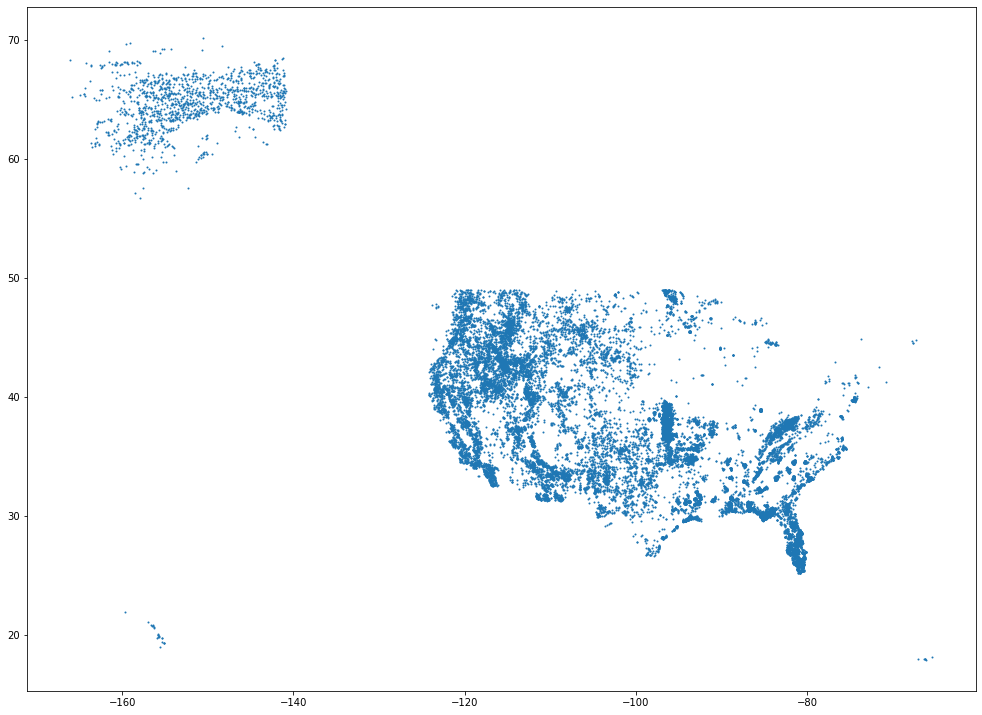

In [23]:
# plot all fires as point data on a map
fires.plot(markersize=1, figsize=(17,17))

In [24]:
# print coordinate reference system of firedata
fires.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [25]:
# print coordinate reference system of state geometry shapefile
states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# reproject fires shapefile so it´s equal to the state geometry shapefile
### 위경도 좌표계로 변환(재투영)
fires = fires.to_crs({'init': 'epsg:4326'})

/Users/choyeon/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [27]:
# perform spatial join
state_fires = geopandas.sjoin(fires, states[['name', 'geometry']].copy(), op='within')
state_fires.head(3)

<ipython-input-27-cb1ca7b12bc9>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  state_fires = geopandas.sjoin(fires, states[['name', 'geometry']].copy(), op='within')


,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,ORIG_FID,geometry,index_right,name
0,UT4176411148820121004,None,HELLS HOLLOW,Prescribed Fire,414,MTBS,Extended,4758,41.766,-111.507,...,-970,-150,113,345,616,None,0,POINT (-111.50798 41.75847),12,Utah
373,UT3986511069320120624,None,CHURCH CAMP,Wildfire,1395,MTBS,Extended,7016,39.897,-110.663,...,-970,-150,50,302,580,None,373,POINT (-110.66860 39.89244),12,Utah
382,UT4054911295520120727,None,DALLAS CANYON,Wildfire,1412,MTBS,Initial,43386,40.633,-112.949,...,-970,-150,50,300,9999,None,382,POINT (-112.94539 40.62365),12,Utah


In [28]:
# create pandas dataframe object with states and fire count
counts_per_state = state_fires.groupby('name').size()    
# list highest values first 
### 이름을 기준으로 산불의 수 내림차순 정렬
counts_per_state.sort_values(axis=0, ascending=False).head(3)

name
Florida       4836
Kansas        1904
California    1813
dtype: int64

In [29]:
# add values to the original shapefile data as a new field
states = states.merge(counts_per_state.reset_index(name='number_of_fires'))        
# list first five rows of shapefile
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry,number_of_fires
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,Minnesota,Minnesota,Миннесота,Minnesota,Minnesota,Minnesota,明尼蘇達州,1159315297,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",433
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,Montana,Montana,Монтана,Montana,Montana,Montana,蒙大拿州,1159315333,"POLYGON ((-116.04823 49.00037, -113.05950 49.0...",760
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,Dakota Północna,Dakota do Norte,Северная Дакота,North Dakota,Kuzey Dakota,Bắc Dakota,北达科他州,1159315337,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",78


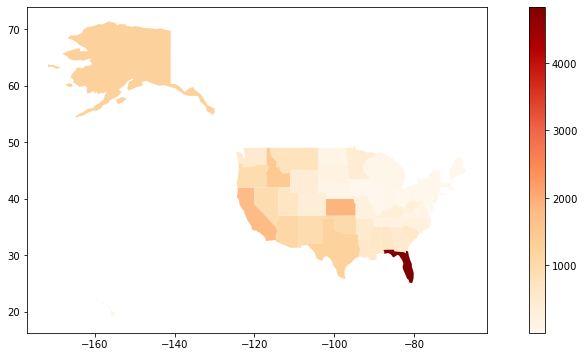

In [30]:
# create map with wildfire date per state
### 연속형에 추천
ax = states.plot(column='number_of_fires', figsize=(15, 6), cmap='OrRd', legend=True)

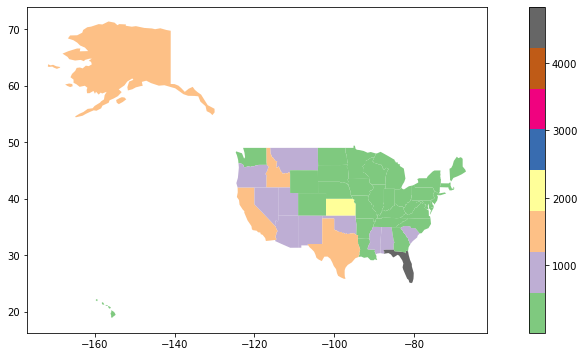

In [59]:
# same map with different colour scheme
### 카테고리 데이터에 추천
ax = states.plot(column='number_of_fires', figsize=(15, 6), cmap='Accent', legend=True)

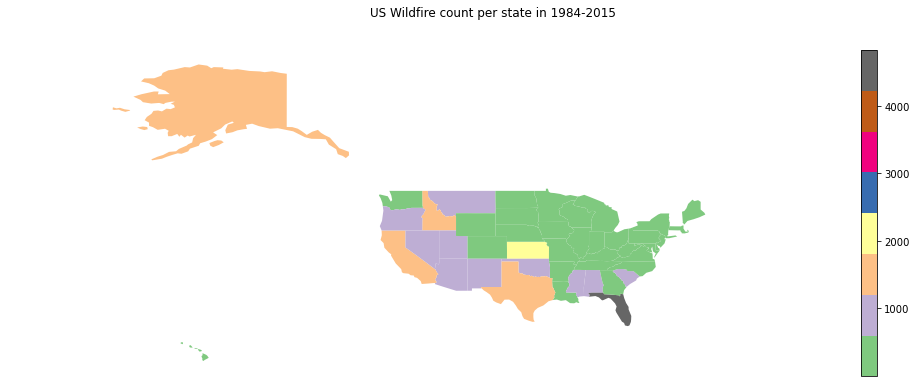

In [60]:
# same map, but without x and y axes and added title
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(18,6))
ax = states.plot(column='number_of_fires', cmap='Accent', legend=True, ax=ax)
lims = plt.axis('equal')
f.suptitle('US Wildfire count per state in 1984-2015')     
ax.set_axis_off()
plt.show()

## 데이터 검증 문제


누락이 있는지 확인

In [70]:
### 전체 행(산불 발생 건수)
len(fires.index)

26558

In [69]:
### 공간 결합에서 누락 발생: 107건
counts_per_state.sum()

26451

In [65]:
### 빈 값 확인
fires.empty

False

In [74]:
### 열 이름을 통한 빈 값 확인
fires.geometry.empty

False